# **Klasifikasi Penyakit Alzheimer**

Proyek ini berfokus pada pengembangan sistem klasifikasi otomatis untuk mendeteksi tingkat keparahan penyakit Alzheimer berdasarkan citra medis MRI (Magnetic Resonance Imaging). Dengan memanfaatkan teknik pemrosesan citra dan kecerdasan buatan, proyek ini bertujuan untuk membantu proses skrining awal dalam membedakan berbagai stadium atrofi otak.

Model ini dilatih untuk mengklasifikasikan citra MRI ke dalam 4 kategori klinis:

- **Non Demented** → Kondisi otak normal tanpa indikasi demensia.
- **Very Mild Demented** → Indikasi awal gejala demensia yang sangat ringan.
- **Mild Demented** → Gejala demensia tingkat ringan dengan perubahan struktural otak yang mulai terlihat.
- **Moderate Demented** → Penurunan fungsi kognitif dan atrofi otak tingkat sedang.

Untuk mendapatkan hasil klasifikasi yang paling akurat, penelitian ini menguji tiga pendekatan arsitektur Deep Learning yang berbeda:

- **1. Custom CNN (Baseline Model)**
- **2. MobileNetV2 (Transfer Learning & Fine-Tuning)**
- **3. VGG16 (Advanced Transfer Learning)**

Dataset yang digunakan dalam proyek ini adalah **[Augmented Alzheimer MRI Dataset](https://www.kaggle.com/datasets/uraninjo/augmented-alzheimer-mri-dataset)**, yang diperoleh dari platform Kaggle. Dataset ini terdiri dari citra medis MRI otak yang telah dikumpulkan dan diproses untuk membantu tugas klasifikasi penyakit neurodegeneratif.

## **Extract Data, Split Data (Train, Val, Test), Setup Input Pipeline, Visualisasi Sample Data**

In [ ]:
import zipfile
import os

zip_path = '/content/dataset_alzheimer.zip'
extract_path = '/content/extracted_data'

if os.path.exists(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Ekstraksi Berhasil! File ada di folder:", extract_path)
else:
    print("File zip tidak ditemukan. Pastikan Anda sudah upload file ke folder /content/")

File zip tidak ditemukan. Pastikan Anda sudah upload file ke folder /content/


In [ ]:
import os
import shutil
import random

# Tentukan path sumber dan tujuan
source_path = '/content/extracted_data/AugmentedAlzheimerDataset'
base_dir = '/content/dataset_final'

classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

# Buat folder struktur (Train, Val, Test)
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

print("Struktur folder Train, Val, dan Test telah siap.")

Struktur folder Train, Val, dan Test telah siap.


In [ ]:
# Lakukan looping untuk setiap kelas
for cls in classes:
    src_cls_dir = os.path.join(source_path, cls)

    # Ambil semua list nama file gambar di folder tersebut
    all_images = [f for f in os.listdir(src_cls_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Ambil 1250 gambar secara acak (Sampling)
    sampled_images = random.sample(all_images, 1250)

    # Acak ulang hasil sampling sebelum dibagi ke folder split
    random.shuffle(sampled_images)

    # Menentukan batasan indeks untuk split
    train_split = 1000  # Indeks 0-999
    val_split = 1125    # Indeks 1000-1124 (selisih 125)
    # Sisa indeks 1125-1249 adalah untuk test (125 gambar)

    for i, img_name in enumerate(sampled_images):
        source_file = os.path.join(src_cls_dir, img_name)

        if i < train_split:
            dest_folder = os.path.join(base_dir, 'train', cls)
        elif i < val_split:
            dest_folder = os.path.join(base_dir, 'val', cls)
        else:
            dest_folder = os.path.join(base_dir, 'test', cls)

        # Copy file ke folder tujuan
        shutil.copy(source_file, os.path.join(dest_folder, img_name))

    print(f"Selesai memproses kelas: {cls}")

print("\n--- SEMUA PROSES SELESAI ---")

Selesai memproses kelas: MildDemented
Selesai memproses kelas: ModerateDemented
Selesai memproses kelas: NonDemented
Selesai memproses kelas: VeryMildDemented

--- SEMUA PROSES SELESAI ---


In [ ]:
def count_files(path):
    for root, dirs, files in os.walk(path):
        if not dirs: # Hanya print folder paling dalam
            print(f"{root}: {len(files)} gambar")

print("Jumlah data di dataset_final:")
count_files(base_dir)

Jumlah data di dataset_final:
/content/dataset_final/train/MildDemented: 1000 gambar
/content/dataset_final/train/NonDemented: 1000 gambar
/content/dataset_final/train/VeryMildDemented: 1000 gambar
/content/dataset_final/train/ModerateDemented: 1000 gambar
/content/dataset_final/val/MildDemented: 125 gambar
/content/dataset_final/val/NonDemented: 125 gambar
/content/dataset_final/val/VeryMildDemented: 125 gambar
/content/dataset_final/val/ModerateDemented: 125 gambar
/content/dataset_final/test/MildDemented: 125 gambar
/content/dataset_final/test/NonDemented: 125 gambar
/content/dataset_final/test/VeryMildDemented: 125 gambar
/content/dataset_final/test/ModerateDemented: 125 gambar


In [ ]:
import tensorflow as tf

# Tentukan parameter utama
IMG_SIZE = (224, 224) # Standar untuk model CNN dan Pretrained (ResNet/MobileNet)
BATCH_SIZE = 32
BASE_PATH = '/content/dataset_final'

# 1. Load Data Training
train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_PATH, 'train'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int' # Label berupa angka (0, 1, 2, 3)
)

# 2. Load Data Validation
val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_PATH, 'val'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int'
)

# 3. Load Data Testing
test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(BASE_PATH, 'test'),
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='int',
    shuffle=False # Jangan di-shuffle untuk kebutuhan Confusion Matrix nanti
)

# Ambil nama kelas untuk referensi
class_names = train_ds.class_names
print("Nama kelas yang terdeteksi:", class_names)

def preprocess_mobilenet(image, label):
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

train_ds = train_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess_mobilenet, num_parallel_calls=tf.data.AUTOTUNE)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

Found 4000 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Found 500 files belonging to 4 classes.
Nama kelas yang terdeteksi: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


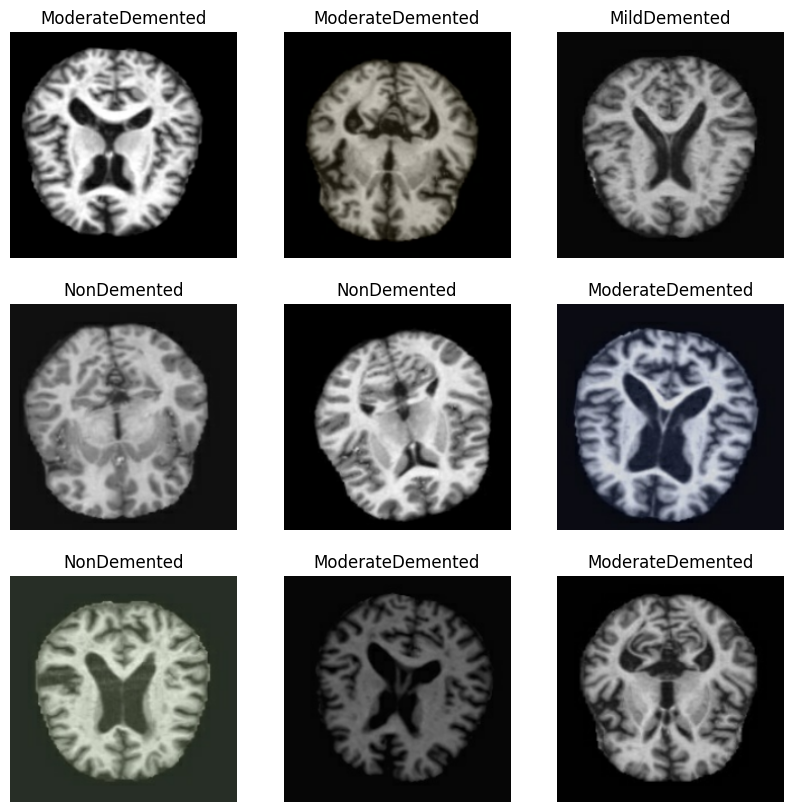

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

## **Build Model CNN**

In [ ]:
from tensorflow.keras import layers, models, callbacks

def build_pro_cnn():
    model = models.Sequential([
        layers.Rescaling(1./255, input_shape=(224, 224, 3)),

        # Blok Konvolusi 1
        layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Blok Konvolusi 2
        layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Blok Konvolusi 3
        layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Blok Konvolusi 4 (Opsional, untuk fitur lebih dalam)
        layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
        layers.BatchNormalization(),

        # MENGGANTI FLATTEN DENGAN GLOBAL AVERAGE POOLING
        layers.GlobalAveragePooling2D(),

        # Fully Connected Layer
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4), # Sedikit diturunkan karena GAP sudah membantu regularisasi
        layers.Dense(4, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Inisialisasi
base_model = build_pro_cnn()
base_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 457,156 (1.74 MB)

 Trainable params: 456,196 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# Setup Callbacks agar training lebih cerdas
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Jalankan Training
history_base = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Set tinggi tidak apa-apa karena ada EarlyStopping
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 25s 92ms/step - accuracy: 0.3491 - loss: 1.3292 - val_accuracy: 0.2620 - val_loss: 2.2227 - learning_rate: 0.0010
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.4742 - loss: 1.1460 - val_accuracy: 0.3060 - val_loss: 1.7592 - learning_rate: 0.0010
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5119 - loss: 1.0629 - val_accuracy: 0.2860 - val_loss: 1.9020 - learning_rate: 0.0010
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6050 - loss: 0.8894 - val_accuracy: 0.2880 - val_loss: 2.4982 - learning_rate: 0.0010
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6350 - loss: 0.7881
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6350 - loss: 0.7882 - val_accuracy: 0.2880 - val_loss: 3.1372 - learning_rate: 0.0010
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.6499 - loss: 0

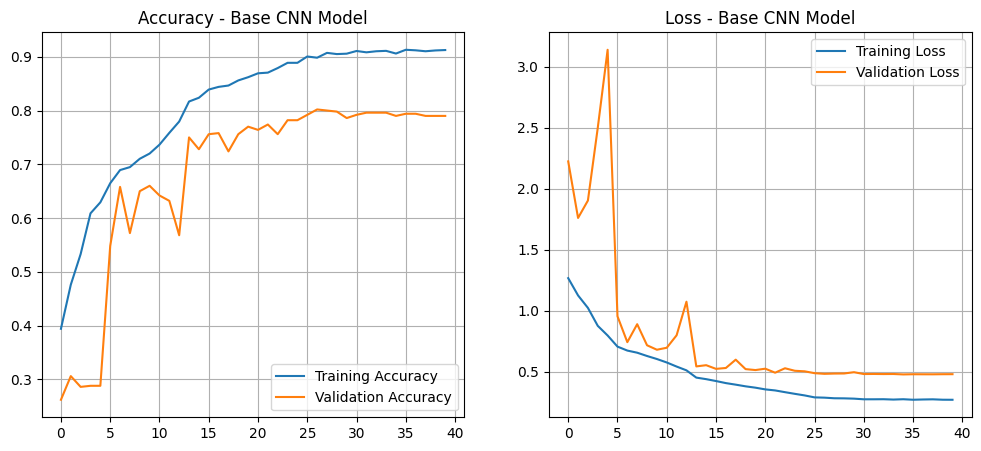

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Grafik Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(True)

    # Grafik Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Loss - {model_name}')
    plt.legend(loc='upper right')
    plt.grid(True)

    plt.show()

# Panggil fungsi untuk Base Model
plot_history(history_base, "Base CNN Model")


=== CLASSIFICATION REPORT ===
                  precision    recall  f1-score   support

    MildDemented       0.75      0.85      0.79       125
ModerateDemented       0.98      1.00      0.99       125
     NonDemented       0.79      0.62      0.69       125
VeryMildDemented       0.62      0.66      0.64       125

        accuracy                           0.78       500
       macro avg       0.78      0.78      0.78       500
    weighted avg       0.78      0.78      0.78       500



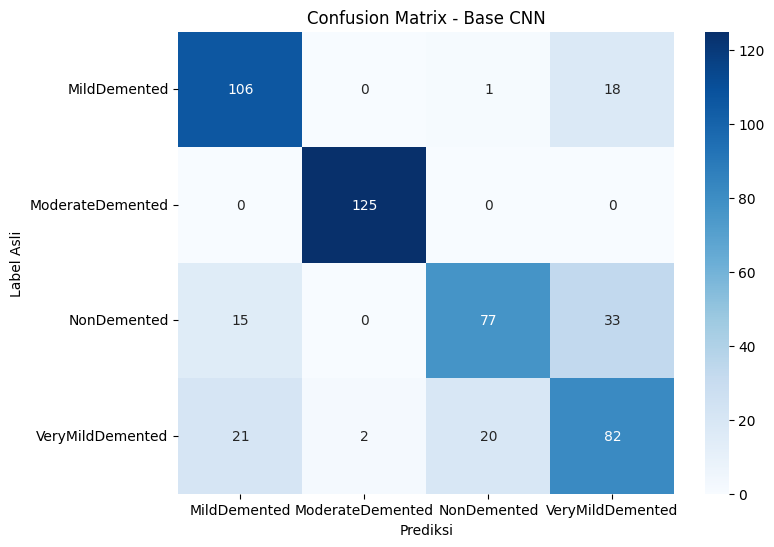

In [ ]:
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Ambil label asli dan prediksi dari test_ds
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = base_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Tampilkan Classification Report
print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_true, y_pred, target_names=class_names))

# 3. Visualisasi Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prediksi')
plt.ylabel('Label Asli')
plt.title('Confusion Matrix - Base CNN')
plt.show()

In [ ]:
base_model.save('model_alzheimer_base.keras')
print("Model Base CNN berhasil disimpan!")

Model Base CNN berhasil disimpan!


## **Build Model MobileNetV2**

In [ ]:
from tensorflow.keras import regularizers
# 1. Gunakan fungsi preprocessing khusus MobileNetV2 (Sangat Penting!)
# MobileNet mengharapkan input pixel antara -1 hingga 1
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 2. Ambil Base Model
base_mobilenet = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# 3. Fine-Tuning: Buka 20 layer terakhir untuk belajar pola MRI
base_mobilenet.trainable = True
for layer in base_mobilenet.layers[:-20]:
    layer.trainable = False

# 4. Susun Arsitektur
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05), # Rotasi sedikit saja karena ini MRI
  layers.RandomZoom(0.05),
])

# 1. Pastikan TIDAK ADA Rescaling(1./255) sebelum ini jika pakai preprocess_input
model_pre1 = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(lambda x: tf.keras.applications.mobilenet_v2.preprocess_input(x)),
    base_mobilenet,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(), # Tambahkan untuk stabilisasi
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)), # Naikkan kapasitas
    layers.Dropout(0.6),
    layers.Dense(4, activation='softmax')
])

# 5. Compile dengan Learning Rate Rendah
# Gunakan LR rendah (0.0001) agar tidak merusak bobot pretrained yang sudah bagus
model_pre1.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 6. Training dengan Epoch lebih banyak (15-20)
# Tambahkan Callback Early Stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,          # Berhenti jika val_loss tidak turun selama 5 epoch
    restore_best_weights=True # Ambil bobot terbaik, bukan bobot terakhir
)

print("Melatih ulang sedikit lebih lama dengan Early Stopping...")
history_pre1 = model_pre1.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50, # Kita set 25, tapi bisa berhenti lebih cepat jika sudah optimal
    callbacks=[callback]
)

model_pre1.save('model_alzheimer_mobilenet.keras')

Melatih ulang sedikit lebih lama dengan Early Stopping...
Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - accuracy: 0.3573 - loss: 9.2136 - val_accuracy: 0.2560 - val_loss: 8.9039
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.5593 - loss: 8.2436 - val_accuracy: 0.2700 - val_loss: 9.0480
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6228 - loss: 7.8274 - val_accuracy: 0.3100 - val_loss: 8.3589
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6655 - loss: 7.4579 - val_accuracy: 0.4400 - val_loss: 7.8087
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.6948 - loss: 7.1543 - val_accuracy: 0.5340 - val_loss: 7.4017
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7112 - loss: 6.8639 - val_accuracy: 0.4880 - val_loss: 7.3567
Epoch 7/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - accuracy: 0.7404 - loss: 6.5646 - val_accuracy: 0.5940 - val_loss: 6.7754
Epoch 8/50
125/125 ━━━━━━━━━━━━━━━━━━━

In [ ]:
def evaluasi_lengkap(model, history, dataset_test, model_name):
    print(f"\n{'='*20} EVALUASI {model_name.upper()} {'='*20}")

    # 1. VISUALISASI GRAFIK
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Loss - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. PREDIKSI DATA TEST
    y_true = []
    y_pred = []
    for images, labels in dataset_test:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # 3. CLASSIFICATION REPORT
    # Menggunakan variabel global 'class_names' yang sudah didefinisikan sebelumnya
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 4. VISUALISASI CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Label Asli')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()


==================== EVALUASI MOBILENETV2 FINAL ====================


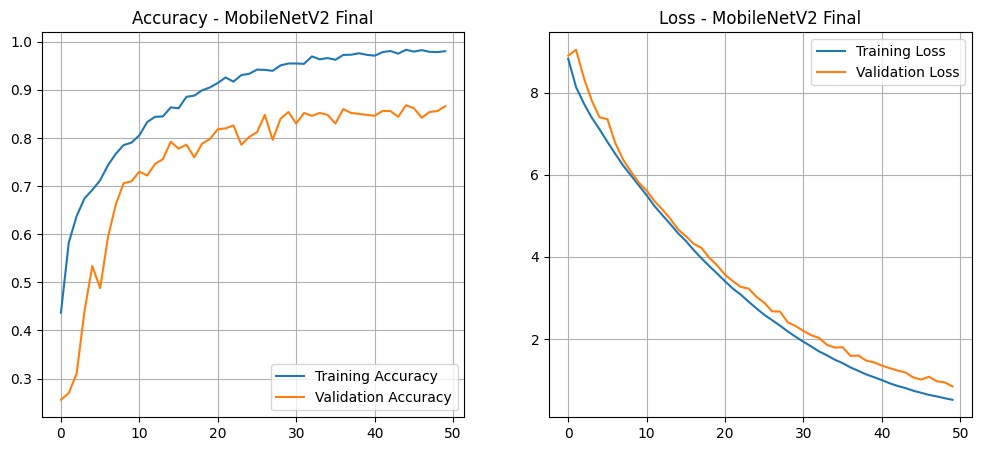


Classification Report - MobileNetV2 Final:
                  precision    recall  f1-score   support

    MildDemented       0.83      0.91      0.87       125
ModerateDemented       0.99      1.00      1.00       125
     NonDemented       0.80      0.82      0.81       125
VeryMildDemented       0.82      0.70      0.76       125

        accuracy                           0.86       500
       macro avg       0.86      0.86      0.86       500
    weighted avg       0.86      0.86      0.86       500



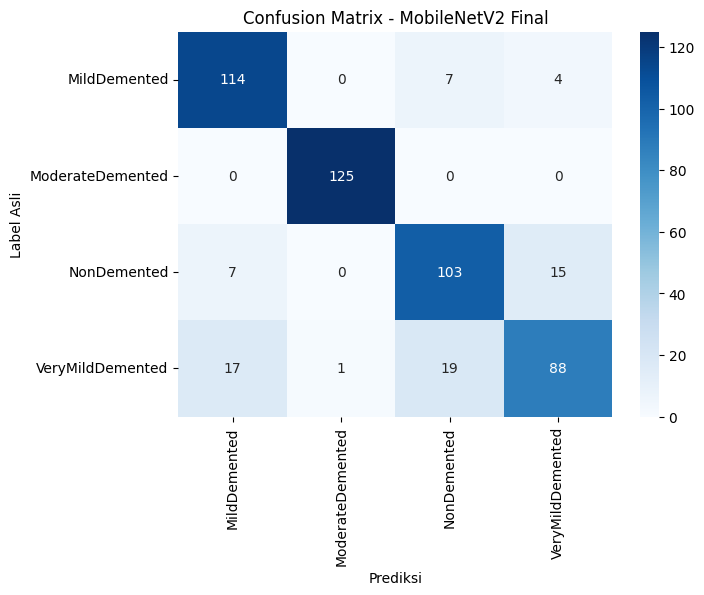

In [ ]:
evaluasi_lengkap(model_pre1, history_pre1, test_ds, "MobileNetV2 Final")

## **Build Model VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.05),
    layers.RandomContrast(0.1)
])

train_ds = train_ds.map(
    lambda x, y: (preprocess_input(data_augmentation(x)), y),
    num_parallel_calls=AUTOTUNE
)

val_ds = val_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)

test_ds = test_ds.map(
    lambda x, y: (preprocess_input(x), y),
    num_parallel_calls=AUTOTUNE
)


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

NUM_CLASSES = len(class_names)

base_model = VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.6),

    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Fine-tuning block4 & block5
for layer in base_model.layers:
    if 'block4' in layer.name or 'block5' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_9      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,768,900 (60.15 MB)

 Trainable params: 14,032,388 (53.53 MB)

 Non-trainable params: 1,736,512 (6.62 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=4,
        min_lr=1e-6
    ),
    ModelCheckpoint(
        filepath='vgg16_best_model.keras',  # ✅ FORMAT KERAS
        monitor='val_accuracy',
        save_best_only=True
    )
]


In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=40,
    callbacks=callbacks
)


Epoch 1/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 30s 158ms/step - accuracy: 0.2965 - loss: 1.5194 - val_accuracy: 0.2500 - val_loss: 9.9926 - learning_rate: 1.0000e-04
Epoch 2/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.5905 - loss: 0.9073 - val_accuracy: 0.5340 - val_loss: 1.4855 - learning_rate: 1.0000e-04
Epoch 3/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.6747 - loss: 0.7166 - val_accuracy: 0.5000 - val_loss: 2.7926 - learning_rate: 1.0000e-04
Epoch 4/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 111ms/step - accuracy: 0.7006 - loss: 0.6454 - val_accuracy: 0.3220 - val_loss: 2.4003 - learning_rate: 1.0000e-04
Epoch 5/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.7614 - loss: 0.5507 - val_accuracy: 0.5460 - val_loss: 1.3060 - learning_rate: 1.0000e-04
Epoch 6/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 117ms/step - accuracy: 0.7997 - loss: 0.4631 - val_accuracy: 0.6980 - val_loss: 1.1245 - learning_rate: 1.0000e-04
Epoch 7/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 11


==================== EVALUASI VGG16 FINAL ====================


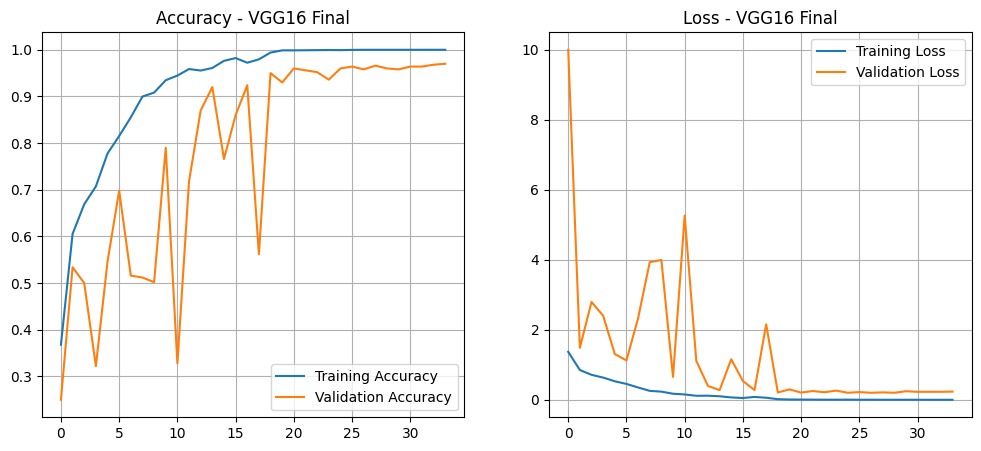


Classification Report - VGG16 Final:
                  precision    recall  f1-score   support

    MildDemented       0.95      0.98      0.96       125
ModerateDemented       1.00      1.00      1.00       125
     NonDemented       0.93      0.95      0.94       125
VeryMildDemented       0.97      0.91      0.94       125

        accuracy                           0.96       500
       macro avg       0.96      0.96      0.96       500
    weighted avg       0.96      0.96      0.96       500



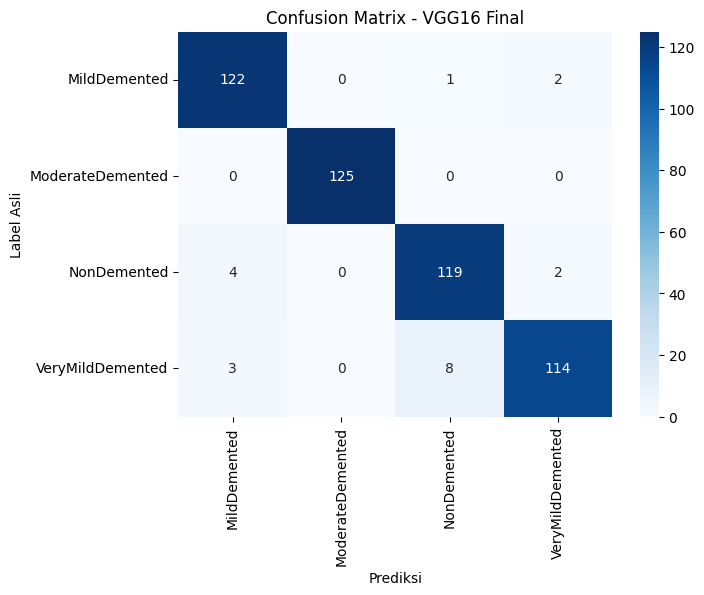

In [ ]:
# Fungsi evaluasi lengkap (sama seperti yang kamu miliki sebelumnya)
def evaluasi_lengkap(model, history, dataset_test, model_name, class_names):
    print(f"\n{'='*20} EVALUASI {model_name.upper()} {'='*20}")

    # 1. VISUALISASI GRAFIK
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.title(f'Accuracy - {model_name}')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.title(f'Loss - {model_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

    # 2. PREDIKSI DATA TEST
    y_true = []
    y_pred = []
    for images, labels in dataset_test:
        preds = model.predict(images, verbose=0)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(preds, axis=1))

    # 3. CLASSIFICATION REPORT
    print(f"\nClassification Report - {model_name}:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # 4. VISUALISASI CONFUSION MATRIX
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel('Prediksi')
    plt.ylabel('Label Asli')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

evaluasi_lengkap(model,history,test_ds,"VGG16 Final",class_names)

In [ ]:
model.save("vgg16_final_model.keras")


In [ ]:
import os

class_names = sorted(os.listdir('/content/dataset_final/train'))
print(class_names)

with open("class_names.json", "w") as f:
    json.dump(class_names, f)


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [ ]:
model_cnn = tf.keras.models.load_model("model_alzheimer_base.keras")

In [ ]:
model_vgg = tf.keras.models.load_model("vgg16_final_model.keras")

## **Visualisasi Perbandingan**

=== TABEL METRIK (DESIMAL) ===


,Model,Accuracy,Precision,Recall,F1-Score
0,CNN Manual,0.780,0.783247,0.780,0.778078
1,MobileNetV2,0.860,0.859757,0.860,0.858145
2,VGG16,0.842,0.892831,0.842,0.846201


=== TABEL METRIK (PERSEN) ===


,Model,Accuracy,Precision,Recall,F1-Score
0,CNN Manual,78.0,78.32,78.0,77.81
1,MobileNetV2,86.0,85.98,86.0,85.81
2,VGG16,84.2,89.28,84.2,84.62


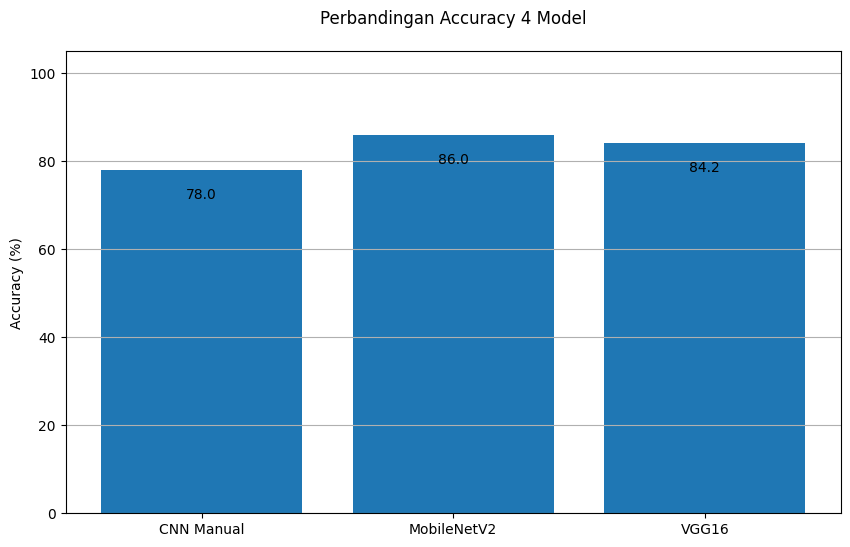

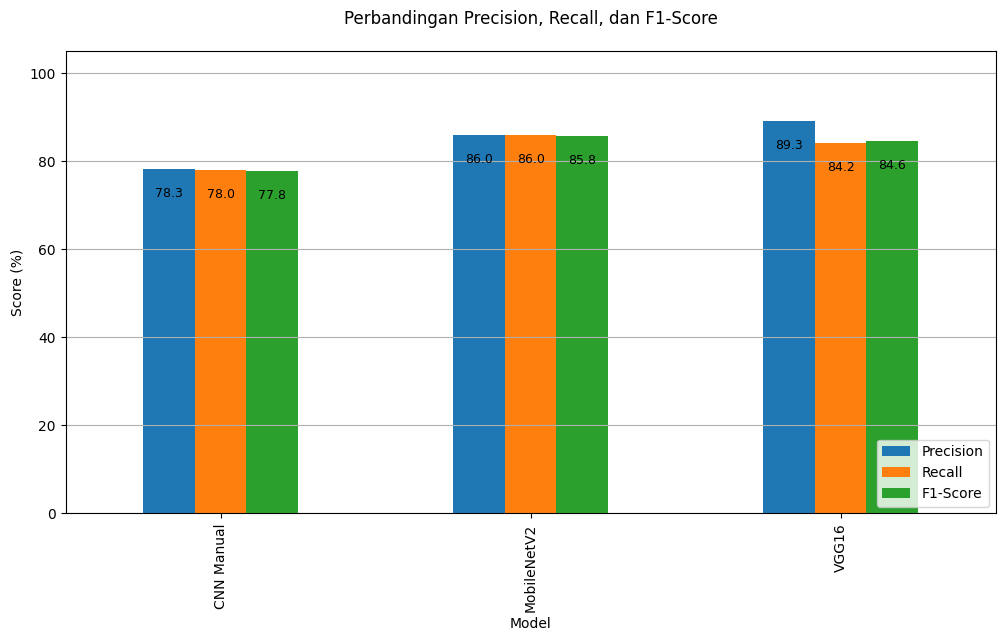

In [ ]:
# =====================================================
# IMPORT LIBRARY
# =====================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# =====================================================
# FUNGSI EVALUASI MODEL
# =====================================================
def evaluate_model(model, test_ds):
    y_true = []
    y_pred = []

    for x, y in test_ds:
        pred = model.predict(x, verbose=0)
        y_pred.extend(np.argmax(pred, axis=1))
        y_true.extend(y.numpy())  # ⬅️ FIX UTAMA

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    f1 = f1_score(y_true, y_pred, average="weighted")

    return acc, precision, recall, f1

# =====================================================
# HITUNG METRIK KESELURUHAN 4 MODEL
# =====================================================
results = []

acc, prec, rec, f1 = evaluate_model(model_cnn, test_ds)
results.append(["CNN Manual", acc, prec, rec, f1])

acc, prec, rec, f1 = evaluate_model(model_pre1, test_ds)
results.append(["MobileNetV2", acc, prec, rec, f1])

acc, prec, rec, f1 = evaluate_model(model_vgg, test_ds)
results.append(["VGG16", acc, prec, rec, f1])


# =====================================================
# TABEL SUMMARY (DESIMAL)
# =====================================================
df_results = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
)

print("=== TABEL METRIK (DESIMAL) ===")
display(df_results)

# =====================================================
# TABEL SUMMARY (PERSEN – UNTUK LAPORAN)
# =====================================================
df_percent = df_results.copy()
for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    df_percent[col] = (df_percent[col] * 100).round(2)

print("=== TABEL METRIK (PERSEN) ===")
display(df_percent)

# =====================================================
# VISUALISASI 1: BAR CHART ACCURACY + LABEL %
# =====================================================
plt.figure(figsize=(10,6))
bars = plt.bar(df_percent["Model"], df_percent["Accuracy"])

plt.title("Perbandingan Accuracy 4 Model", pad=20)
plt.ylabel("Accuracy (%)")
plt.ylim(0, 105)  # ⬅️ FIX
plt.grid(axis="y")

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height - 4,          # ⬅️ masuk ke batang
        f"{height:.1f}",
        ha="center",
        va="top",
        fontsize=10,
        color="black"
    )

plt.show()


# =====================================================
# VISUALISASI 2: PRECISION, RECALL, F1-SCORE + LABEL %
# =====================================================
metrics = ["Precision", "Recall", "F1-Score"]

ax = df_percent.set_index("Model")[metrics].plot(
    kind="bar",
    figsize=(12,6)
)

plt.title("Perbandingan Precision, Recall, dan F1-Score", pad=20)
plt.ylabel("Score (%)")
plt.ylim(0, 105)  # ⬅️ FIX UTAMA
plt.grid(axis="y")
plt.legend(loc="lower right")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.annotate(
            f"{height:.1f}",
            (bar.get_x() + bar.get_width()/2, height - 4),  # ⬅️ masuk ke batang
            ha="center",
            va="top",
            fontsize=9,
            color="black"
        )

plt.show()

